In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.api import VAR, DynamicVAR, VARMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyramid.arima import auto_arima
import pytemperature

In [2]:
nights = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv', index_col='date', parse_dates=['date'], 
                          usecols=[*range(1, 15)])
nights.index.freq = 'MS'
temp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
temp = pytemperature.c2k(temp)
daysoff = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
gdp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])

### Corrected Seasonal MASE function
- Finally correct this time!! 3rd time's a charm... 
- Problem with previous Seasonal MASE was that we never used Seaonality=12 argument with proper inputs; the adjusted function below is easier to use and gives accurate results

In [3]:
def seasonal_MASE(last_season, this_season, forecast):
    '''
    Parameters
    ----------
    last_season: series with dates containing data for last season (size S)
    
    current_truth: series with dates containing data for current season (size S)
    
    forecast: series with dates containing data predicting current season (size S)
    '''
    forecast_errors = np.abs(this_season - forecast)
    #print(forecast_errors)
    mean_absolute_forecast_error = np.average(forecast_errors)
    #print('forecast MAE', mean_absolute_forecast_error)
    
    naive = last_season
    naive.index = this_season.index
    naive_errors = np.abs(this_season - naive)
    #print(naive_errors)
    mean_absolute_naive_error = np.average(naive_errors)
    #print('naive MAE', mean_absolute_naive_error)
    
    return mean_absolute_forecast_error / mean_absolute_naive_error

In [4]:
start_year, end_year, predict_year = '2010', '2013', '2014'
region = 'IDF'

input_data = pd.concat([nights, temp, daysoff, gdp], axis=1).dropna()
input_data = input_data[[f'nights_{region}',
                         f'avgtemp_{region}',
                         f'gdp_{region}',
                         'daysoff']]
target = nights[[f'nights_{region}']]

training_period = (input_data.index>=start_year)&(input_data.index<end_year) 
testing_period = (target.index>=end_year)&(target.index<predict_year)

train_data = input_data[training_period]
test_data = np.array(target[testing_period])

train_data.drop(f'gdp_{region}', axis=1)

# --------Seasonal decompose----------
decomposed_data = seasonal_decompose(
    train_data, model='multiplicative', extrapolate_trend='freq')  
seasonal_data, trend_data, residual_data = (decomposed_data.seasonal,
                                            decomposed_data.trend, decomposed_data.resid)

# ---------Seasonal prediction (Same as last year of training data)---------
seasonal_train = seasonal_data[
    (seasonal_data.index>=start_year)&(seasonal_data.index<end_year)]
seasonal_forecast = pd.DataFrame(seasonal_train[f'nights_{region}'].values[-12:])

# --------Trend prediction (Linear Holt)----------

trend = Holt(trend_data[f'nights_{region}']).fit(optimized=True)
trend_forecast = pd.DataFrame(trend.predict(start=0, end=11).values)


# --------Residual prediction (VAR)----------
resid_model = VAR(residual_data, dates=residual_data.index)    
resid_results = resid_model.fit(3)
lag_order = resid_results.k_ar
resid_forecast = pd.DataFrame(
    resid_results.forecast(residual_data.values[-lag_order:], 12))

# --------Recomposing results----------
forecast = seasonal_forecast[0] * trend_forecast[0] * resid_forecast[0]
forecast.index = target[f'nights_{region}'][testing_period].index

In [5]:
forecast

date
2013-01-01    4320.363257
2013-02-01    4147.845855
2013-03-01    5265.471470
2013-04-01    5603.960663
2013-05-01    6070.206396
2013-06-01    6229.190156
2013-07-01    6380.082489
2013-08-01    5752.775653
2013-09-01    5965.227291
2013-10-01    5982.047781
2013-11-01    4880.979447
2013-12-01    5225.540863
Freq: MS, Name: 0, dtype: float64

### Comparing IDF 2013 truth vs. VAR 2013 forecast vs. Naive 2013 forecast (repeat of 2012 values)
- The naive forecast which just puts 2012 values onto 2013 as a forecast is still surprisingly accurate!
- Seasonal MASE = 1.075 meaning that VAR forecast error is larger than the seasonal naive forecast error: The complicated model isn't better!

In [6]:
seasonal_MASE(nights.nights_IDF['2012'], nights.nights_IDF['2013'], forecast)

1.0757368530460694

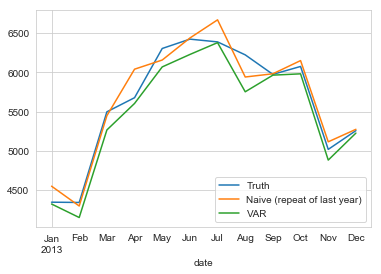

In [7]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
nights.nights_IDF['2013'].plot(ax=ax, label='Truth')
naive = nights.nights_IDF['2012']
naive.index = nights.nights_IDF['2013'].index
naive.plot(ax=ax, label='Naive (repeat of last year)')
forecast.plot(ax=ax, label='VAR')
plt.legend();